<div style='padding:5px'><font style='font-weight:bold;font-size:32px;color:#2c3393;'>Here Comes The Sun: Clark Solar Power Plant</font></div>
<div style='padding:5px'><font style='font-weight:bold;font-size:24px;color:#2c3393;'>LT16 - Sandro Silva and Jac Lin Yu</font></div>
<div style='padding:5px'><font style='font-weight:bold;font-size:15px;color:#2c3393;'>Individual Project of Sandro Silva</font><div>

------------

<font style='font-weight:bold;font-size:32px;color:#2c3393;'>Table of Contents</font>


<font style='font-size:16px'>
    
**[1. Problem Statement](#problem-statement)**

**[2. Methodology](#methodology)**

  * [2.1. Loading Prerequisites](#preq)
  * [2.2. Dataset and Preprocessing](#data)
  * [2.3. Train, Validation, Test Split and Batch Generation](#train)
  * [2.4. Determining the Benchmark](#benchmark)
  * [2.5. Model Training and Selection](#model)
      * [2.5.1 LSTM with 64 nodes](#lstm1)
      * [2.5.2 LSTM with 32 nodes](#lstm2)
      * [2.5.3 Stacked LSTM with 64 and 32 nodes](#lstm3)
      * [2.5.4 Stacked LSTM with 32 and 64 nodes](#lstm4)   

**[3. Results and Discussions](#results)**
  * [3.1. Results](#res)
  * [3.2. Discussions and Recommendations](#discussions)
    
**[4. Summary and Main Learning Points](#summary)**
  * [4.1. Summary](#summary)
  * [4.1. Main Learning Points](#main)
</font>

<div id="problem-statement"/>
<div style='padding:3px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>1. Problem Statement</font></div>

<div style='padding-left: 20px; text-align: justify; font-size:16px; line-height:1.6'>
In recent years, the global energy industry has changed its focus away from traditional fuel sources, such as oil and coal, to more alternative and sustainable solutions, such as hydroelectric, solar and wind. However, the shift towards renewable energy poses new threats and challenges to existing power grids across the world. One major concern surrounding renewable energy generation is the inherent variability and intermittency of its fuel source, as this can cause disruptions in power grids. Essentially, renewable energy technologies threaten to overwhelm the grid operators.
<br><br> 
Renewable energy forecasting, in particular solar generation supply, may provide power grid operators the ability to predict and balance energy generation and consumption. In addition, power grid operators will be able to balance and schedule the distribution of generated power for not only renewable power plants but also conventional (and rigid) power plants, such as coal and natural gas.
</div>

<div id="methodology"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>2. Methodology</font></div>

<div id="preq"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.1 Loading Prerequisites</font></div>

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

<div id="data"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.2 Dataset and Preprocessing</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
Here, we will load the already cleaned preprocessed dataset of solar generation per plant per hour.
The cleaning was processed outside of this notebook, and followed a framework which follows the industry standard of imputing missing values.
  
    
<b>To list a few processes:</b>
    - using the average between the before(t-1) and after hour(t+1)
    - using a 1-week average of all similar intervals 
    (ex, if empty during hour 6 of dec 20, take the moving average of all hour 6 from dec 13-dec19)
    - using a 4-week moving average of that specific hour and day of the week 
    (ex, if empty during hour 6 of dec 20, we take average of hour 6(dec 13, 6, 29, 22)
</font></div>

In [4]:
df = pd.read_excel('solar_dataset.xlsx', 
                   sheet_name='clark', 
                   parse_dates=['DATETIME'])

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
Here let us observe the different datatypes, notice that some columns are objects, some of which will be dropped.
    </font></div>

In [4]:
df.dtypes

DATETIME         datetime64[ns]
YEAR                      int64
MONTH                     int64
DAY                       int64
HOUR                      int64
RESOURCE_ID              object
MW                      float64
Location                 object
Temperature             float64
Dew Point               float64
Humidity                float64
Wind Speed              float64
Wind Gust                 int64
Pressure                float64
Condition                object
Location_Name            object
dtype: object

In [5]:
df.head(3)

,DATETIME,YEAR,MONTH,DAY,HOUR,RESOURCE_ID,MW,Location,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Condition,Location_Name
0,2016-12-26 00:00:00,2016,12,26,1,1CLASOL_G01,0.0,RPLC,75.0,70.0,83.0,5.0,0,29.3,Light Rain Shower,ANGELES/PAMPANGA
1,2016-12-26 01:00:00,2016,12,26,2,1CLASOL_G01,0.0,RPLC,77.0,68.0,74.0,9.0,0,29.2,Cloudy,ANGELES/PAMPANGA
2,2016-12-26 02:00:00,2016,12,26,3,1CLASOL_G01,0.0,RPLC,77.0,70.0,78.0,9.0,0,29.2,Light Rain Shower,ANGELES/PAMPANGA


<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    It is customary in traditional time-series regression to convert the <code>month</code>, <code>day</code>, 
    <code>hour</code> into categorical data, which will be later used in one-hot encoding. In addition, this is the usual preprocessing used in the energy industry here in the Philippines.
</font></div>

In [6]:
df.MONTH = df.MONTH.astype('str')
df.DAY = df.DAY.astype('str')
df.HOUR = df.HOUR.astype('str')

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us drop the unimportant columns
</font></div>

In [7]:
df.drop(['Location_Name', 'Location', "YEAR"],axis=1,inplace=True)

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us append the main <code>df</code> with the one-hot encoded dataframe
</font></div>

In [8]:
df = df.join(pd.get_dummies(df[['MONTH','DAY','HOUR','Condition']]))

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us get the unique list of power plants in the region
</font></div>

In [9]:
locations = df.RESOURCE_ID.unique()

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    For this study, let us consider the first power plant
</font></div>

In [10]:
locations[0]

'1CLASOL_G01'

In [11]:
df0 = df[df.RESOURCE_ID == locations[0]].copy()

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Further dropping of columns as well as reordering of columns
</font></div>

In [12]:
df0 = df0.drop(['RESOURCE_ID','DATETIME','MONTH','DAY','HOUR','Condition'],
               axis=1)

In [13]:
df0 = df0[['Temperature','MW'] + df0.columns[2:].tolist()].copy()

In [14]:
df0 = df0.astype('float')

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Final <code>DataFrame</code> to be used
</font></div>

In [15]:
df0.head()

,Temperature,MW,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,MONTH_1,MONTH_10,MONTH_11,...,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Patches of Fog,Condition_Rain,Condition_Rain / Windy,Condition_Rain Shower,Condition_Showers in the Vicinity,Condition_T-Storm,Condition_Thunder
0,75.0,0.0,70.0,83.0,5.0,0.0,29.3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,77.0,0.0,68.0,74.0,9.0,0.0,29.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,77.0,0.0,70.0,78.0,9.0,0.0,29.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79.0,0.0,70.0,74.0,12.0,0.0,29.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,79.0,0.0,70.0,74.0,12.0,0.0,29.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df0.shape

(24031, 101)

In [17]:
plant_capacity = 22

<div id="train"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>
    2.3 Train,Validate,Test Split and Batch Generation</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    For this analysis, a <code>.8</code>, <code>.1</code>, <code>.1</code>, train-validate-test split was implemented. Since we are dealing with a time-series, the train-validate-test split cannot be randomly selected from the dataset, splitting of dataset should be conducted in a chronogical order. Below we define the starting and ending <code>index</code> for each group
</font></div>

In [18]:
train_validate_test_split = [.8, .1, .1]

train_idx = math.floor(df0.shape[0] * train_validate_test_split[0])
val_idx = math.floor(df0.shape[0] * train_validate_test_split[1]) + train_idx

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    The <code>generator</code> function below was utilized to yield the appropriate batch. Significant parameters include the <code>lookback</code>, or how far back of the data to consider, <code>delay</code>, or how far into the future are we forecasting, <code>batch_size</code>, refers to the number of training examples utilized in one iteration.
</font></div>

In [19]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, 
              batch_size=128, step=1):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, 
                                     max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us mean-center the dataset
</font></div>

In [20]:
float_data = df0.values
train_mean = float_data[:train_idx].mean(axis=0)
float_data -= train_mean
train_std = float_data[:train_idx].std(axis=0)
float_data /= train_std
train_mw_std = train_std[1]

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    Let us initialize the parameters which will be used for the generation
    An industry standard practic is to utilize a <code>lookback</code> of either <code>144 hours</code> (1 week), <code>288 hours</code> (2 weeks), or <code>720 hours</code> (1[30-day] month). The initial run was to utilized a <code>288 hour</code> lookback period due to group's industry expert's experience. However, outside consultation with industry experts said 1 week would suffice with this limited dataset.
</font></div>

In [21]:
lookback = 144 # lookback(consider) the previous week data
step = 1 # in hourly granularity
delay = 24 # to forecast the next 24 hours
batch_size = 128

In [22]:
train_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=train_idx,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=train_idx+1,
    max_index=val_idx,
    step=step,
    batch_size=batch_size)

test_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=val_idx,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (val_idx - (train_idx+1) - lookback)
test_steps = (len(float_data) - (val_idx+1) - lookback)

<div id="benchmark"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.4 Benchmark</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
    The team used two metrics to establish a baseline error:
    
    (1) the naive method identified in a previous lecture, which we scaled to industry standard
    (2) a different framework suggested by industry
</font></div>

In [23]:
def evaluate_naive_method():

    batch_maes = []
    for step in range(val_steps):
        if step % 1000 == 0:
            print(step)
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    return np.mean(batch_maes)

naive_method = evaluate_naive_method()

0
1000
2000


In [24]:
print('NAIVE METHOD 1:', f'{((naive_method * train_mw_std)/22):0.2%}') #where 22 is the capacity of the plant

NAIVE METHOD 1: 6.58%


In [25]:
benchmark1 = ((naive_method * train_mw_std)/22) * 100

<div style='padding:5px;text-align:justify'> <font style='font-style:italic;font-size:17px;color:#2c3393;'>
For establishing the 2nd baseline error, the team consulted the industry to determine a baseline error. However, even the industry is still conflicted on how to establish a baseline measurement. As of now, the baseline is still being established by policy makers and grid operators. 
<br>   
    
Luckily, consulting with industry experts gave the team a framework on how to establish a baseline error per plant. The resulting measure looked at the mean squared error of the day-ahead projection(DAP), also called scheduled (Ex-Ante or RTD), and the actual delivered (Ex-Post or RTX).
    
    
This was then scaled as a percentage to the capacity of the plant. This was with processed with an industry expert and not included in the notebook. The yielding error resulted with a baseline of <code>12.01%</code>
</font></div>

In [26]:
benchmark2 = 12.01

<div id="model"/>
<div style='padding:5px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5 Model Training Selection</font></div>

<div style='padding:5px;'> <font style='font-style:italic;font-size:15px;color:#2c3393;'>
The team utilized 4 models:
    
    - LSTM with 64 nodes
    - LSTM with 32 nodes
    - Stacked LSTM(2 layer) with 64 and 32 nodes
    - Stacked LSTM(2 layer) with 32 and 64 nodes
    
Dropout of <code>0.2</code> and Recurrent Dropout of <code>0.2</code> and a <code>RMSProp</code> optimized was implemented for all three.

The group decided to use a <code>Epoch=50</code>, with an EarlyStopping of <code>patience=10</code> and <code>min_delta=0.01</code> to avoid overfitting and to reduce runtime due to the limited time constraints. Lastly, the ModelCheckpoint was utilized to extract the best model.
</font></div>

In [27]:
steps_per_epoch_cnt = math.floor(train_idx/batch_size)
val_steps_cnt = round(math.floor((val_idx-train_idx)/batch_size),-1)

<div id="lstm1"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.1 LSTM with 64</font></div>

In [28]:
filepath_lstm64="clark_best_lstm64.hdf5" 
cp_lstm64 = ModelCheckpoint(filepath_lstm64, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm64 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm64 = [cp_lstm64, es_lstm64]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm64 = Sequential()
model_lstm64.add(layers.LSTM(64, 
                       dropout=0.2,
                       recurrent_dropout=0.2, 
                       input_shape=(None, float_data.shape[-1])))
model_lstm64.add(layers.Dense(64,activation='relu'))
model_lstm64.add(layers.Dense(1))
model_lstm64.compile(optimizer=RMSprop(), loss='mae')

history_lstm64 = model_lstm64.fit_generator(train_gen,
                                        steps_per_epoch=steps_per_epoch_cnt, 
                                        epochs=50,
                                        validation_data=val_gen, 
                                        validation_steps=val_steps_cnt,
                                        callbacks=callbacks_list_lstm64, verbose=2) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
20/20 [==============================] - 1s 47ms/step - loss: 0.1993

Epoch 00001: val_loss improved from inf to 0.19933, saving model to clark_best_lstm64.hdf5
 - 19s - loss: 0.4025 - val_loss: 0.1993
Epoch 2/50
20/20 [==============================] - 1s 43ms/step - loss: 0.1724

Epoch 00002: val_loss improved from 0.19933 to 0.17236, saving model to clark_best_lstm64.hdf5
 - 19s - loss: 0.2765 - val_loss: 0.1724
Epoch 3/50
20/20 [==============================] - 1s 43ms/step - loss: 0.1564

Epoch 00003: val_loss improved from 0.17236 to 0.15639, saving model to clark_best_lstm64.hdf5
 - 19s - loss: 0.2005 - val_loss: 0.1564
Epoch 4/50
20/20 [==============================] - 1s 42ms/step - loss: 0.1634

Epoch 00004: val_loss did not improve

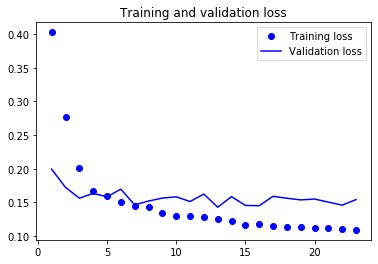

In [29]:
loss_lstm64 = history_lstm64.history['loss']
val_loss_lstm64 = history_lstm64.history['val_loss']

epochs = range(1, len(loss_lstm64) + 1)

plt.figure()

plt.plot(epochs, loss_lstm64, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm64, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
print('Model Error:', f'{((min(val_loss_lstm64) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 3.21%


In [52]:
lstm64 = ((min(val_loss_lstm64) * train_mw_std)/plant_capacity) * 100

<div id="lstm2"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.2 LSTM with 32 nodes</font></div>

In [32]:
filepath_lstm32="clark_best_lstm32.hdf5" 
cp_lstm32 = ModelCheckpoint(filepath_lstm32, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm32 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm32 = [cp_lstm32, es_lstm32]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm32 = Sequential()
model_lstm32.add(layers.LSTM(32, 
                       dropout=0.2,
                       recurrent_dropout=0.2, 
                       input_shape=(None, float_data.shape[-1])))
model_lstm32.add(layers.Dense(32, activation='relu'))
model_lstm32.add(layers.Dense(1))
model_lstm32.compile(optimizer=RMSprop(), loss='mae')

history_lstm32 = model_lstm32.fit_generator(train_gen,
                                        steps_per_epoch=steps_per_epoch_cnt, 
                                        epochs=50,
                                        validation_data=val_gen, 
                                        validation_steps=val_steps_cnt,
                                        callbacks=callbacks_list_lstm32, verbose=2) 

Epoch 1/50
20/20 [==============================] - 1s 41ms/step - loss: 0.1916

Epoch 00001: val_loss improved from inf to 0.19160, saving model to clark_best_lstm32.hdf5
 - 17s - loss: 0.4936 - val_loss: 0.1916
Epoch 2/50
20/20 [==============================] - 1s 34ms/step - loss: 0.1696

Epoch 00002: val_loss improved from 0.19160 to 0.16960, saving model to clark_best_lstm32.hdf5
 - 19s - loss: 0.3050 - val_loss: 0.1696
Epoch 3/50
20/20 [==============================] - 1s 31ms/step - loss: 0.1460

Epoch 00003: val_loss improved from 0.16960 to 0.14600, saving model to clark_best_lstm32.hdf5
 - 17s - loss: 0.2672 - val_loss: 0.1460
Epoch 4/50
20/20 [==============================] - 1s 31ms/step - loss: 0.1610

Epoch 00004: val_loss did not improve from 0.14600
 - 17s - loss: 0.2259 - val_loss: 0.1610
Epoch 5/50
20/20 [==============================] - 1s 35ms/step - loss: 0.1525

Epoch 00005: val_loss did not improve from 0.14600
 - 17s - loss: 0.2027 - val_loss: 0.1525
Epoch 6

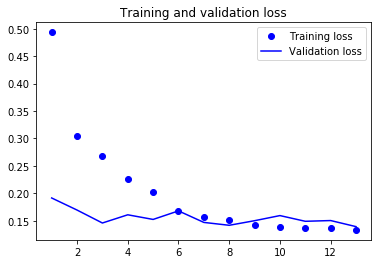

In [33]:
loss_lstm32 = history_lstm32.history['loss']
val_loss_lstm32 = history_lstm32.history['val_loss']

epochs = range(1, len(loss_lstm32) + 1)

plt.figure()

plt.plot(epochs, loss_lstm32, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm32, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
print('Model Error:', f'{((min(val_loss_lstm32) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 3.13%


In [51]:
lstm32 = ((min(val_loss_lstm32) * train_mw_std)/plant_capacity) * 100

<div id="lstm3"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.3 Stacked LSTM with 64 and 32 nodes</font></div>

In [38]:
filepath_lstm6432="clark_best_lstm6432.hdf5" 
cp_lstm6432 = ModelCheckpoint(filepath_lstm6432, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm6432 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm6432 = [cp_lstm6432, es_lstm6432]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm6432 = Sequential()
model_lstm6432.add(layers.LSTM(64,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model_lstm6432.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2))
model_lstm6432.add(layers.Dense(32, activation='relu'))
model_lstm6432.add(layers.Dense(1))
model_lstm6432.compile(optimizer=RMSprop(), loss='mae')

history_lstm6432 = model_lstm6432.fit_generator(train_gen,
                                             steps_per_epoch=steps_per_epoch_cnt,
                                             epochs=50,
                                             validation_data=val_gen, 
                                             validation_steps=val_steps_cnt,
                                             callbacks=callbacks_list_lstm6432, verbose=2)

Epoch 1/50
20/20 [==============================] - 2s 77ms/step - loss: 0.1807

Epoch 00001: val_loss improved from inf to 0.18073, saving model to clark_best_lstm6432.hdf5
 - 35s - loss: 0.4037 - val_loss: 0.1807
Epoch 2/50
20/20 [==============================] - 2s 80ms/step - loss: 0.1452

Epoch 00002: val_loss improved from 0.18073 to 0.14524, saving model to clark_best_lstm6432.hdf5
 - 34s - loss: 0.2290 - val_loss: 0.1452
Epoch 3/50
20/20 [==============================] - 1s 60ms/step - loss: 0.1595

Epoch 00003: val_loss did not improve from 0.14524
 - 41s - loss: 0.1754 - val_loss: 0.1595
Epoch 4/50
20/20 [==============================] - 1s 60ms/step - loss: 0.1460

Epoch 00004: val_loss did not improve from 0.14524
 - 34s - loss: 0.1528 - val_loss: 0.1460
Epoch 5/50
20/20 [==============================] - 1s 70ms/step - loss: 0.1535

Epoch 00005: val_loss did not improve from 0.14524
 - 37s - loss: 0.1483 - val_loss: 0.1535
Epoch 6/50
20/20 [=============================

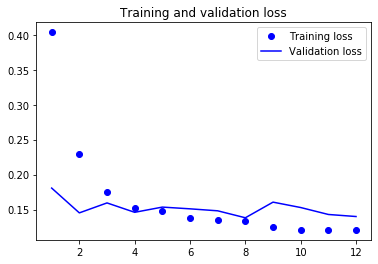

In [39]:
loss_lstm6432 = history_lstm6432.history['loss']
val_loss_lstm6432 = history_lstm6432.history['val_loss']

epochs = range(1, len(loss_lstm6432) + 1)

plt.figure()

plt.plot(epochs, loss_lstm6432, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm6432, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
print('Model Error:', f'{((min(val_loss_lstm6432) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 3.10%


In [49]:
lstm6432 = ((min(val_loss_lstm6432) * train_mw_std)/plant_capacity) * 100

<div id="lstm4"/>
<div style='padding:20px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>2.5.4 Stacked LSTM with 32 and 64 nodes</font></div>

In [42]:
filepath_lstm3264 ="clark_best_lstm3264.hdf5" 
cp_lstm3264 = ModelCheckpoint(filepath_lstm3264, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
es_lstm3264 = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, min_delta=.01)
callbacks_list_lstm3264 = [cp_lstm3264, es_lstm3264]

# fix random seed for reproducibility
seed = 1337
np.random.seed(seed)

model_lstm3264 = Sequential()
model_lstm3264.add(layers.LSTM(64,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model_lstm3264.add(layers.LSTM(32,
                    dropout=0.2,
                    recurrent_dropout=0.2))
model_lstm3264.add(layers.Dense(64, activation='relu'))
model_lstm3264.add(layers.Dense(1))
model_lstm3264.compile(optimizer=RMSprop(), loss='mae')

history_lstm3264 = model_lstm3264.fit_generator(train_gen,
                                             steps_per_epoch=steps_per_epoch_cnt,
                                             epochs=50,
                                             validation_data=val_gen, 
                                             validation_steps=val_steps_cnt,
                                             callbacks=callbacks_list_lstm3264, verbose=2)

Epoch 1/50
20/20 [==============================] - 2s 77ms/step - loss: 0.1807

Epoch 00001: val_loss improved from inf to 0.18071, saving model to clark_best_lstm3264.hdf5
 - 36s - loss: 0.4016 - val_loss: 0.1807
Epoch 2/50
20/20 [==============================] - 1s 65ms/step - loss: 0.1537

Epoch 00002: val_loss improved from 0.18071 to 0.15374, saving model to clark_best_lstm3264.hdf5
 - 33s - loss: 0.2138 - val_loss: 0.1537
Epoch 3/50
20/20 [==============================] - 1s 65ms/step - loss: 0.1639

Epoch 00003: val_loss did not improve from 0.15374
 - 33s - loss: 0.1709 - val_loss: 0.1639
Epoch 4/50
20/20 [==============================] - 1s 64ms/step - loss: 0.1513

Epoch 00004: val_loss improved from 0.15374 to 0.15125, saving model to clark_best_lstm3264.hdf5
 - 33s - loss: 0.1528 - val_loss: 0.1513
Epoch 5/50
20/20 [==============================] - 1s 66ms/step - loss: 0.1401

Epoch 00005: val_loss improved from 0.15125 to 0.14008, saving model to clark_best_lstm3264.h

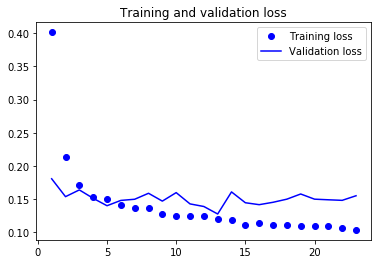

In [43]:
loss_lstm3264 = history_lstm3264.history['loss']
val_loss_lstm3264 = history_lstm3264.history['val_loss']

epochs = range(1, len(loss_lstm3264) + 1)

plt.figure()

plt.plot(epochs, loss_lstm3264, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm3264, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
print('Model Error:', f'{((min(val_loss_lstm3264) * train_mw_std)/plant_capacity):0.2%}')

Model Error: 2.86%


In [50]:
lstm3264 = ((min(val_loss_lstm3264) * train_mw_std)/plant_capacity) *100

<div id="results"/>
<div style='padding:3px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>3. Results and Discussions</font></div>

In [53]:
names = ['Industry Agnostic Naive Method',
         'Industry Standard Naive Method', 
         'LSTM with 64 nodes',
         'LSTM with 32 nodes',
         'LSTM+LSTM with 64 nodes and 32 nodes',
         'LSTM+LSTM with 32 nodes and 64 nodes']
results = [benchmark1, 
           benchmark2,
           lstm64,
           lstm32,
           lstm6432,
           lstm3264]

In [54]:
results = pd.DataFrame(zip(names,results), columns=['Model', 'Error in Percentage'])

In [57]:
results['Error in Percentage'] = round(results['Error in Percentage'],2)

In [71]:
results['Improvement'] = round(1-(results['Error in Percentage']/12.01),4)*100

In [72]:
results

,Model,Error in Percentage,Improvement
0,Industry Agnostic Naive Method,6.58,45.21
1,Industry Standard Naive Method,12.01,0.00
2,LSTM with 64 nodes,3.21,73.27
3,LSTM with 32 nodes,3.13,73.94
4,LSTM+LSTM with 64 nodes and 32 nodes,3.10,74.19
5,LSTM+LSTM with 32 nodes and 64 nodes,2.86,76.19


<div id="res"/>
<div style='padding:10px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>3.1 Results</font></div>

<div style='text-align:justify; line-height:1.8'>
<font style='font-style:italic;font-size:16px;color:#2c3393;'>
Results are indicated in the table above. All four models appear to have performed better than the naive models by quite a margin, with the Two layer LSTM with 64 nodes and 32 nodes having the lowest error in terms of percentage. This translates to an improvement by 73.27% (LSTM with 64 nodes), 73.94% (LSTM with 32 nodes), 74.19% (LSTM+LSTM with 64 nodes and 32 nodes) and 76.19% (LSTM+LSTM with 32 nodes and 64 nodes).
</font></div>

<div id="discuss"/>
<div style='padding:10px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>3.2 Discussions and Recommendations</font></div>

<div style='text-align:justify; line-height:1.8'>
<font style='font-style:italic;font-size:16px;color:#2c3393;'>
<p style='text-align:justify; line-height:1.8'>
Adding more epochs and allowing the model train even longer would have some benefits. Results could have improved on all four models if the <code>patience</code> and the <code>min_delta</code> were relaxed.
    
My recommendation is to include more technical data in the dataset. Based on industry knowledge, irridiance is one of the main drivers of forecasting solar generation. I would expect that including this as a feature would drastically improve the already impressive model results. Similarly, adding power grid data such as power line capacity and degradation, solar panel angle, may improve in each models accuracy.</p>
    
<p style='text-align:justify; line-height:1.8'>Moving forward, I would want to explore different types of architectures. Similar journal articles suggested using an LSTM-CNN and/or a CNN-LSTM architectures. These two types of models capture not only the temporal data (LSTM) but also the spatial element (CNN). In addition, using a CNN to include images of the panels may improve the models accuracy. as this may capture the overall health of the panel.</p>
</font>
</div> 

<div id="summary"/>
<div style='padding:3px;'> <font style='font-weight:bold;font-size:20px;color:#2c3393;'>4. Summary and Main Learning Points</font></div>

<div id="sum"/>
<div style='padding:10px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>4.1 Summary</font></div>

<div style='text-align:justify; line-height:1.8'>
<font style='font-style:italic;font-size:16px;color:#2c3393;'>
The main objective of the study was to apply deep learning models to forecast solar power supply generation.   The data collected was from two online sources, the Wholesale Electrcity Spot Market and Weather Underground. Actual plant generation was obtained from the Wholesale Electricity Spot Market and 13 locational temperature data (Clark International Airport) was collected from Weather Underground. Next, domain knowledge was utilized in the preprocessing data to impute missing data. Here, two forms of benchmarks were idenfied, one was an industry agnostic standard while another error was sourced through consultation of industry experts. Afterwhich, a total of 4 different LSTM architecures were tested and all seem to have beaten both the industry agnostic and industry standard errors. Dropouts and Recurrent Dropouts were utilized during training as fine tuning of the model. In addition, ModelCheckpoints and EarlyStopping was implemented during the training to monitor the output and reduce the runtime. For the results, the 2 layer LSTM with 32 nodes and 64 nodes had the best improvement of 76.19%, from an 12.01% error to 2.86% error. 
 </font>
</div>

<div id="main"/>
<div style='padding:10px;'> <font style='font-weight:bold;font-size:15px;color:#2c3393;'>4.2 Main Learning Points</font></div>

<div style='text-align:justify; line-height:1.8'>
<font style='font-style:italic;font-size:16px;color:#2c3393;'>
<b>The main role of domain knowledge and expertise can be augmented with data science and machine learning.</b>

<p style='text-align:justify; line-height:1.5;'>
- The class has taught me the fundamentals of machine learning and deep learning algorithms, such as MLP, Convolutional, to Recurrent neural networks. However, what I discovered during this process is that domain knowledge influences and augments the data science flow. Yes, we may have developed the fundamentals of understanding deep learning techniques but the true potential of an algorithm can be truly harnessed only when some form of domain knowledge is utilized. 
</p>
    
<p style='text-align:justify; line-height:1.5'>
- Industry heuristics can improve the data science pipeline from the feature engineering, benchmarking, model selection and hyperparameter turing. That with prior knowledge on the topic at hand can improve on the accuracy of the resulting model. 
</p>
    
<p style='text-align:justify; line-height:1.5'>   
- On the contrary, having industry knowledge can allow me to think more critical with regards to other peoples models (whether in journals or at the office), both from the machine learning and technical perspective. 
</p>
    
<p style='text-align:justify; line-height:1.5'>
- Lastly, one may know the inner workings of the model and know how to implement the model, however with domain knowledge, one will also know how to ask the right questions. Questions relating to (1) business value, on how to extract more value from a model, and/or (2) how can we improve or build on the model. Essentially asking what are the next steps, and how can we improve on this.
</p>    
    
<b>Not really data science related but: tap the industry the topic is related about. You do not know everything in an industry so leverage on the network to figure out things</b>
<p style='text-align:justify; line-height:1.5'>
- Even if I was already in the energy industry, I was not particularly familiar with renewable energy forecasting and the standard protocols. If my groupmate and I were not familiar with the industry, it would have been very difficult for us to verify protocols. However, since I am blessed with very talented people from the industry, a quick 5 minute call was all we needed to verify certain aspect of the industry. 
</p>
    
<p style='text-align:justify; line-height:1.5;font-weight:bold'>Find a field/aspect of data science that you're interested in, stick to it, build on it and fix it!</p>
    
<p style='text-align:justify; line-height:1.5'>
- From the numerous of talks I have listened in this class, it was already ingrained to me that data science is applicable to almost every industry, and as aspiring data scientists it may be difficult to hone in into a certain field or aspect. For me, I find joy when I see the application of data science to the energy sector as I have experienced and seen where the holes in the analytics are. Now, I have the fundamental skillset to cover up and fix these holes.
</p>

</font>
</div>